# 9.11 样式迁移

In [1]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 均已测试

print(device, torch.__version__)

cuda 1.1.0


## 9.11.2 读取内容图像和样式图像

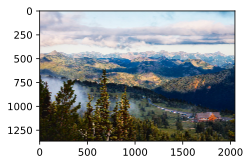

In [2]:
d2l.set_figsize()
content_img = Image.open('../../data/rainier.jpg')
d2l.plt.imshow(content_img);

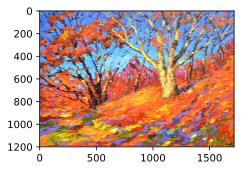

In [3]:
d2l.set_figsize()
style_img = Image.open('../../data/autumn_oak.jpg')
d2l.plt.imshow(style_img);

## 9.11.3. 预处理和后处理图像

In [4]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])

    return process(PIL_img).unsqueeze(dim = 0) # (batch_size, 3, H, W)

def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

## 9.11.4 抽取特征

In [5]:
!echo $TORCH_HOME # 将会把预训练好的模型下载到此处(没有输出的话默认是.cache/torch)
pretrained_net = torchvision.models.vgg19(pretrained=True, progress=True)

/data1/tangss/PyTorch_pretrainedmodels


In [6]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [7]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [8]:
net_list = []
for i in range(max(content_layers + style_layers) + 1):
    net_list.append(pretrained_net.features[i])
net = torch.nn.Sequential(*net_list)

In [9]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [10]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## 9.11.5 定义损失函数
### 9.11.5.1 内容损失

In [11]:
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y)

### 9.11.5.2 样式损失

In [12]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2] * X.shape[3]
    X = X.view(num_channels, n)
    return torch.matmul(X, X.t()) / (num_channels * n)

In [13]:
def style_loss(Y_hat, gram_Y):
    return F.mse_loss(gram(Y_hat), gram_Y)

### 9.11.5.3 总变差损失

In [14]:
def tv_loss(Y_hat):
    return 0.5 * (F.l1_loss(Y_hat[:, :, 1:, :], Y_hat[:, :, :-1, :]) + 
                  F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

### 9.11.5.4 损失函数

In [15]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

## 9.11.6 创建和初始化合成图像

In [16]:
class GeneratedImage(torch.nn.Module):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [17]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data = X.data
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

## 9.11.7 训练

In [18]:
def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
    print("training on ", device)
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.1)
    for i in range(max_epochs):
        start = time.time()
        
        contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        optimizer.zero_grad()
        l.backward(retain_graph = True)
        optimizer.step()
        scheduler.step()
        
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(),
                     time.time() - start))
    return X.detach()

In [19]:
image_shape =  (150, 225)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

training on  cuda
epoch  50, content loss 0.24, style loss 1.11, TV loss 1.33, 0.07 sec
epoch 100, content loss 0.24, style loss 0.81, TV loss 1.20, 0.07 sec
epoch 150, content loss 0.24, style loss 0.72, TV loss 1.12, 0.07 sec
epoch 200, content loss 0.24, style loss 0.68, TV loss 1.06, 0.07 sec
epoch 250, content loss 0.23, style loss 0.68, TV loss 1.05, 0.07 sec
epoch 300, content loss 0.23, style loss 0.67, TV loss 1.04, 0.07 sec
epoch 350, content loss 0.23, style loss 0.67, TV loss 1.04, 0.07 sec
epoch 400, content loss 0.23, style loss 0.67, TV loss 1.03, 0.07 sec
epoch 450, content loss 0.23, style loss 0.67, TV loss 1.03, 0.07 sec


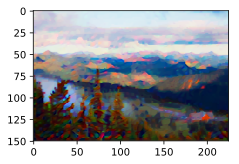

In [20]:
d2l.plt.imshow(postprocess(output));

In [21]:
image_shape = (300, 450)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)

training on  cuda
epoch  50, content loss 0.34, style loss 0.63, TV loss 0.79, 0.18 sec
epoch 100, content loss 0.30, style loss 0.50, TV loss 0.74, 0.18 sec
epoch 150, content loss 0.29, style loss 0.46, TV loss 0.72, 0.18 sec
epoch 200, content loss 0.28, style loss 0.43, TV loss 0.70, 0.18 sec
epoch 250, content loss 0.28, style loss 0.43, TV loss 0.69, 0.18 sec
epoch 300, content loss 0.27, style loss 0.42, TV loss 0.69, 0.18 sec
epoch 350, content loss 0.27, style loss 0.42, TV loss 0.69, 0.18 sec
epoch 400, content loss 0.27, style loss 0.42, TV loss 0.69, 0.18 sec
epoch 450, content loss 0.27, style loss 0.42, TV loss 0.69, 0.18 sec


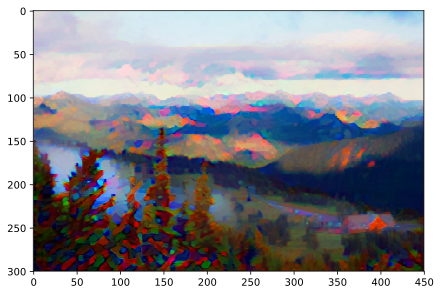

In [22]:
d2l.set_figsize((7, 5))
d2l.plt.imshow(postprocess(big_output));